In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import zipfile
from IPython.display import display, HTML
from sklearn.decomposition import PCA
%matplotlib inline
sns.set()

# Analysis of Discretionary Spending by Brazilian House Members

*TODO*: add references.

[**Data Source**](http://www2.camara.leg.br/transparencia/cota-para-exercicio-da-atividade-parlamentar/dados-abertos-cota-parlamentar), provided by the Brazilian Government (publicly available data).

In this notebook, we analyze the spending of members of the Brazilian Congressmen (*Deputados Federais*) from 2009 to Dec. 2017. The following expenditures are part of the "parlamentary quota" that congressmen can use as part of their activities. 

This analysis is directly inpired by the [*Operação Serenata de Amor*](https://serenata.ai/), and similar results can be found in their [blog](https://serenata.ai/en/stories/) and specifically [this post](https://medium.com/data-science-brigade/precisamos-falar-sobre-a-cota-parlamentar-c58a73392148). We encourage you to check and [support their efforts](https://apoia.se/serenata). 

Metadata description can be found [here](http://www2.camara.leg.br/transparencia/cota-para-exercicio-da-atividade-parlamentar/explicacoes-sobre-o-formato-dos-arquivos-xml) and in the metadata folder.

**Values are not corrected for inflation.**

## Data import and cleanup

The code below unzips and combines the CSV files provided by the Brazilian government. We also process the features to match expected data types. There are a few entries that have problemetic time stamps.

In [3]:
# data directory
data_dir = '../data/'
files = os.listdir(data_dir)
df_list = []

# create datatype dictionary
dtype_dic = {'txNomeParlamentar':str,
 'idecadastro':str,
 'nuCarteiraParlamentar':str,
 'nuLegislatura':str,
 'sgUF':str,
 'sgPartido':str,
 'codLegislatura':str,
 'numSubCota':str,
 'txtDescricao':str,
 'numEspecificacaoSubCota':str,
 'txtDescricaoEspecificacao':str,
 'txtFornecedor':str,
 'txtCNPJCPF':str,
 'txtNumero':str,
 'indTipoDocumento':str,
 'datEmissao':str,
 'vlrDocumento':np.float32,
 'vlrGlosa':np.float32,
 'vlrLiquido':np.float32,
 'numMes':int,
 'numAno':int,
 'numParcela':int,
 'txtPassageiro':str,
 'txtTrecho':str,
 'numLote':int,
 'numRessarcimento':str,
 'vlrRestituicao':str,
 'nuDeputadoId':str,
 'ideDocumento':str}

parse_dates = ['datEmissao']


for f in files:
    
    # check if file is a .csv.zip
    if f[-8:]!='.csv.zip':
            continue
            
    # build path
    filepath = data_dir + f
    
    # creat zip object
    zfile = zipfile.ZipFile(filepath)
    
    # iterate over files in zip
    for finfo in zfile.infolist():
        
        # check if csv
        if finfo.filename[-4:] == '.csv':
            
            # read file, create dataframe, and append to dataframe list
            csv = zfile.open(finfo)

            df_list.append(pd.read_csv(csv,sep=';', decimal=",",parse_dates=parse_dates,dtype=dtype_dic))
            
    
# append to one mega dataframe
df = pd.concat(df_list,ignore_index = True)

# now we fixe dates
def convert_date(x):
    try:
        return pd.to_datetime(x)
    except:
        return x

# fix things that were loaded as strings vs numbers
df.iloc[:,26] = df.iloc[:,26].apply(np.float64)
df['datEmissao'] = df['datEmissao'].apply(convert_date)

# delete list to save memory
del df_list

# We now fix entries whose date 'dataEmissao' do not make sense -- we will relabel them using 'numMes' and 'numAno',
# and put it to the start of the month.
bad_ix = df.loc[df['datEmissao'].apply(lambda x : True if type(x)==str else False)].index.tolist()
bad_ix += df.loc[df['datEmissao'].apply(lambda x : True if (type(x)!=str) and ((x.year>2018) or(x.year<2009)) else False)].index.tolist()
bad_ix = list(set(bad_ix))
for ix in bad_ix:
    year = str(df.loc[ix,'numAno'])
    month = str(df.loc[ix,'numMes'])
    date = pd.to_datetime(year+'-'+month+'-'+'01')
    df.loc[ix,'datEmissao'] = date

# produce valid names
allNames = list(set(list(df['txNomeParlamentar'])))

# get names that only have one word
badNames = [n for n in allNames if  len(n)<5 or (('-' in n) and (' ') not in n)]

df = df[~df['txNomeParlamentar'].isin(badNames)]

## Aggregate spending

Our first task will be to plot the aggregate spending across multiple years. We look at the attribute `vlrLiquido` since, per the metadata, this corresponds to the actual charged value to the congressman's expenditure account.

Text(0.5,1,'Date')

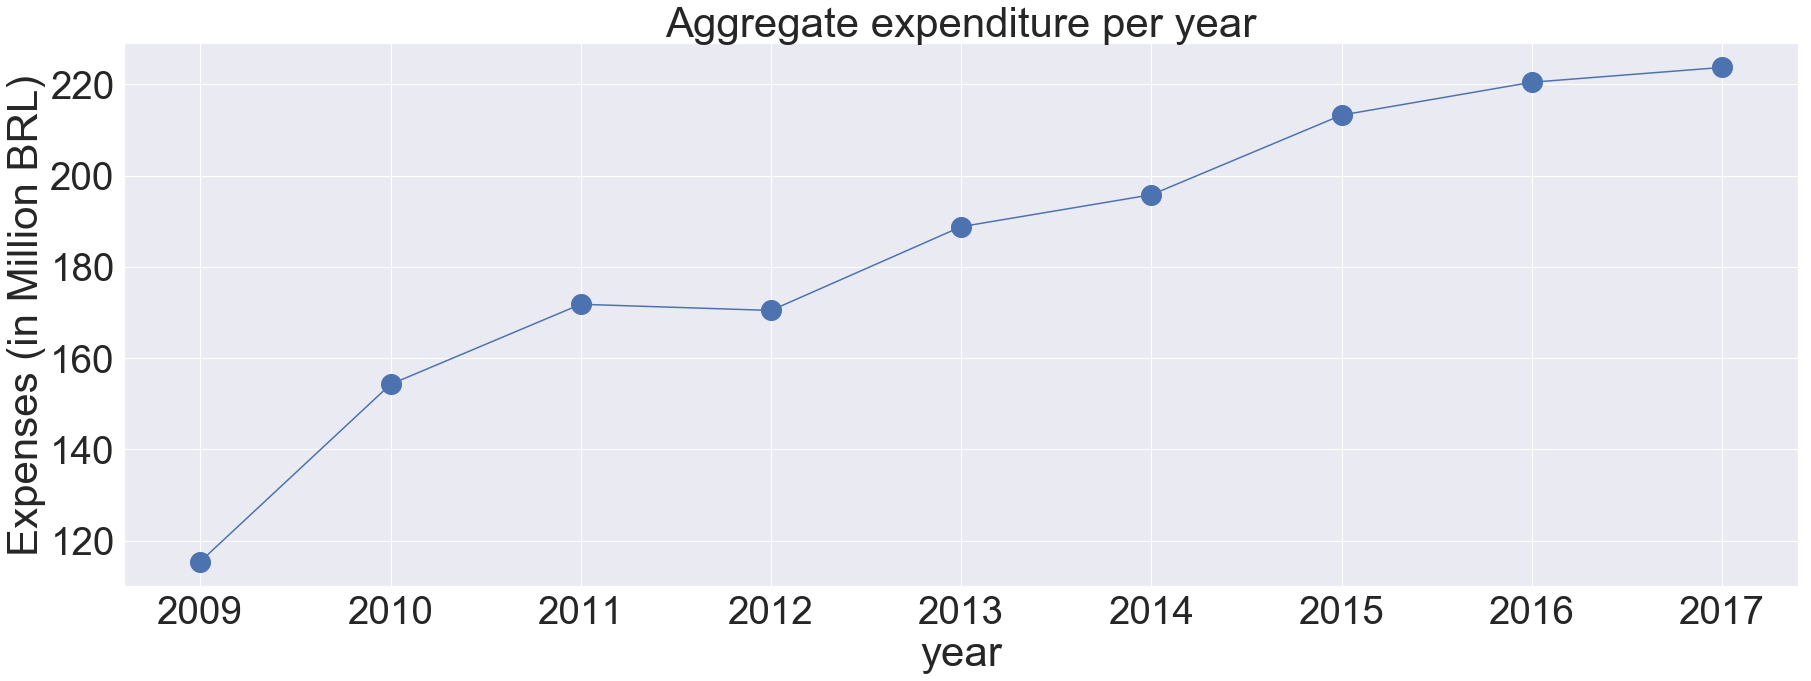

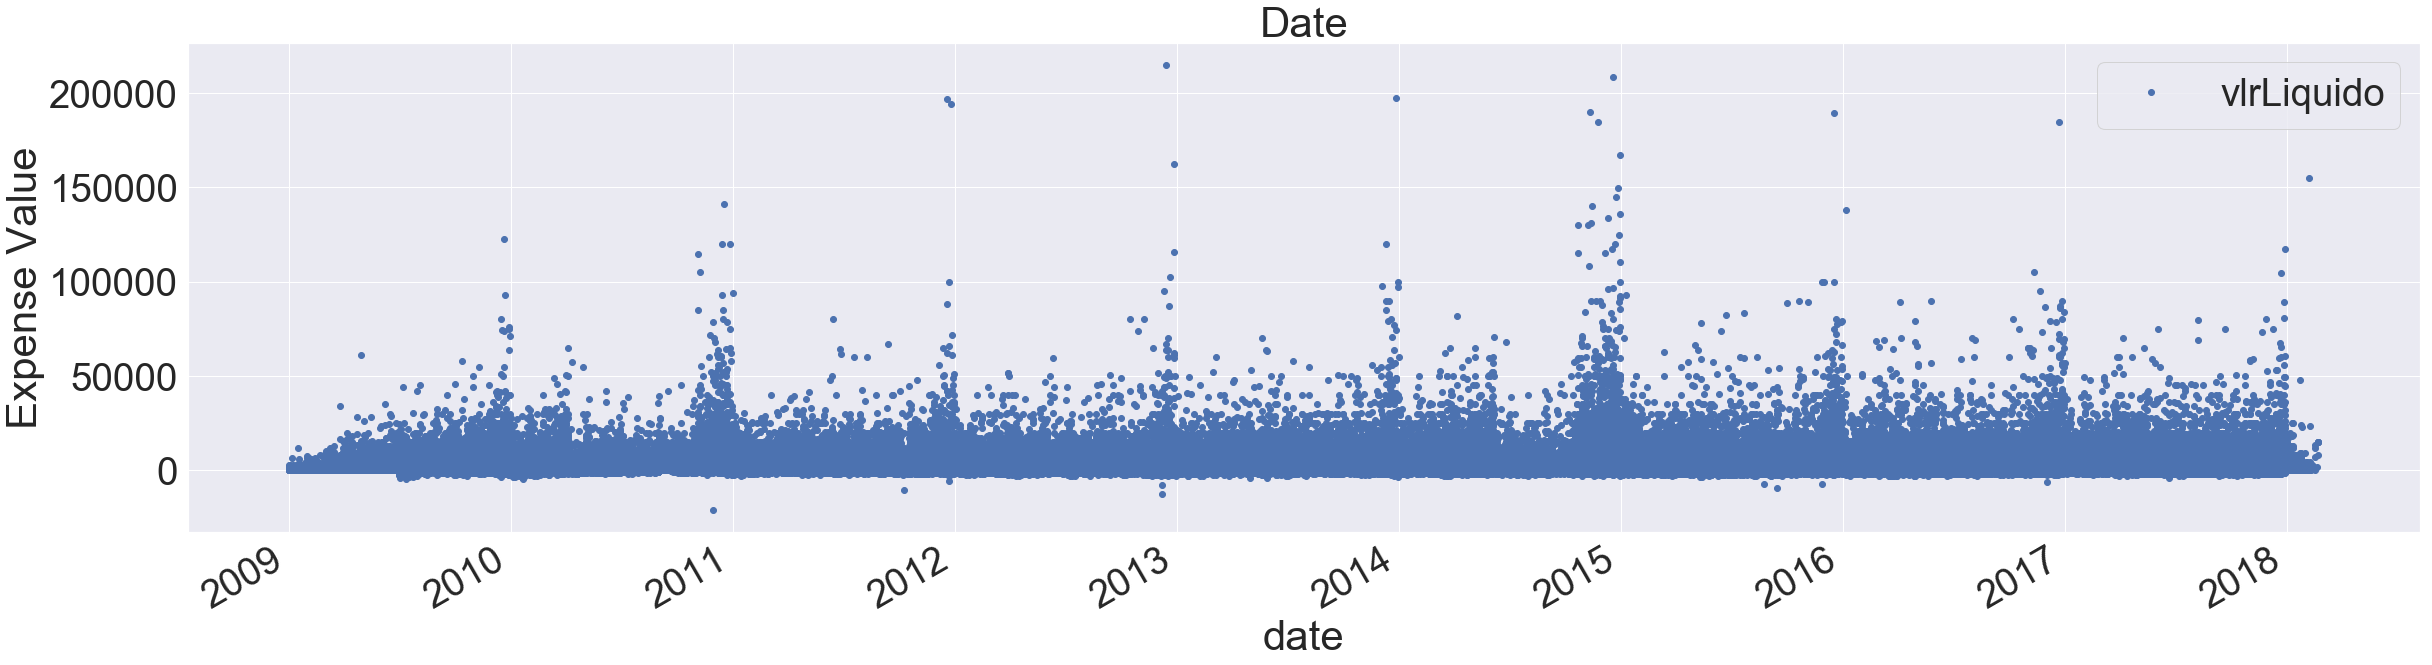

In [4]:
sns.set(font_scale=3.5)
plt.figure(figsize=(30,10))

# time series
ts = df[['datEmissao','vlrLiquido']].copy()

ts.sort_values('datEmissao',inplace=True)
ts.set_index('datEmissao', inplace=True)

# aggregate plot
(df.groupby('numAno')['vlrLiquido'].sum()/1e6).plot(marker='o',markersize=20)
plt.xlabel('year')
plt.ylabel('Expenses (in Million BRL)')
plt.title('Aggregate expenditure per year')

ts.plot(marker='o',linestyle='',figsize=(40,10))
plt.xlabel('date')
plt.ylabel('Expense Value')
plt.title('Date')

There are some very clear outliers on the data, particularly around the end of the year -- perhaps members of congress are trying to meet their yearly allowable budgets? Let's plot the mean and aggregate expense per month of the year across all years in the dataset. Some data is missing from the start of 2009, so we consider 2010-onwards for the monthly analysis.

**We will return to the outliers later.**

Text(0.5,1,'Average expense per month')

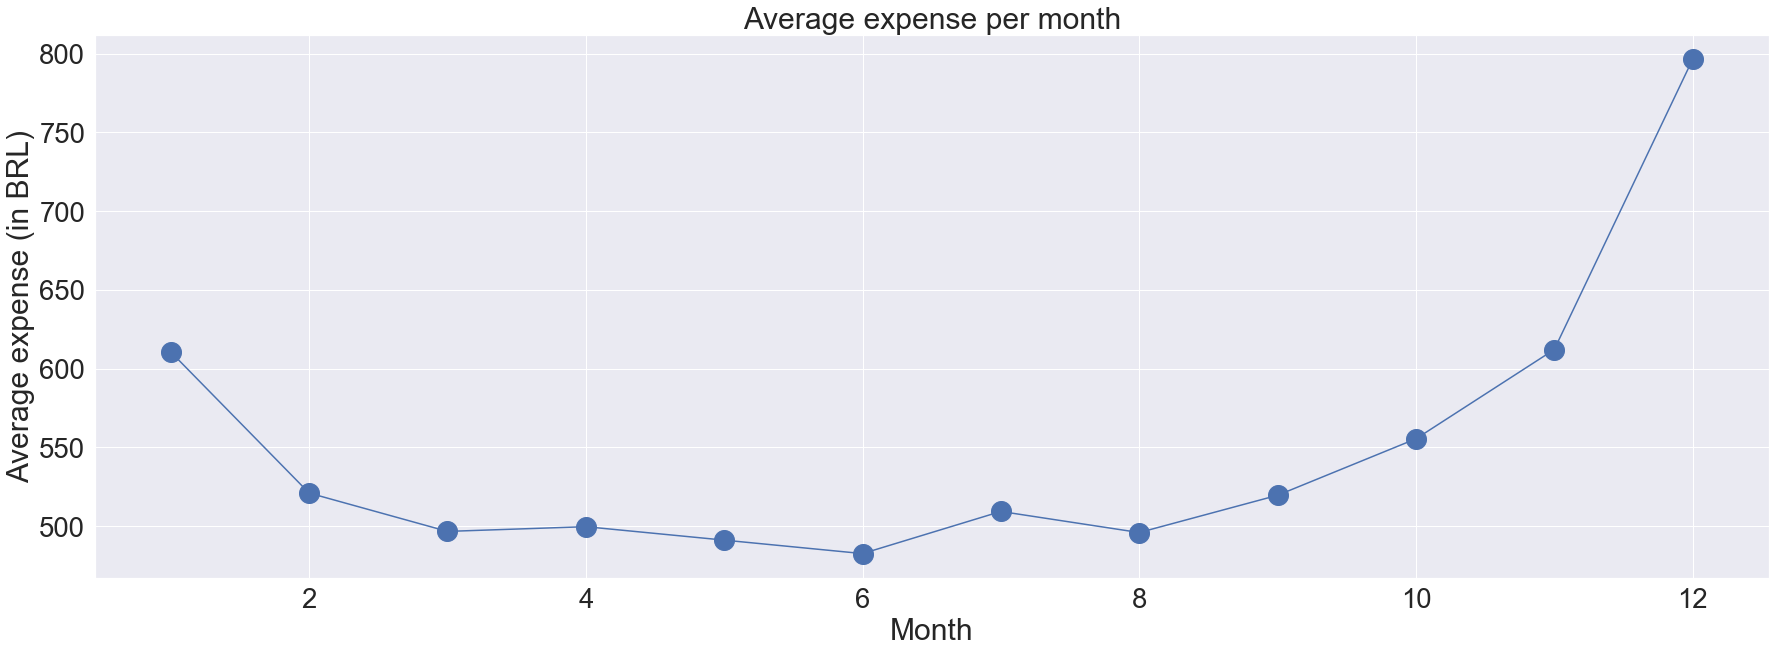

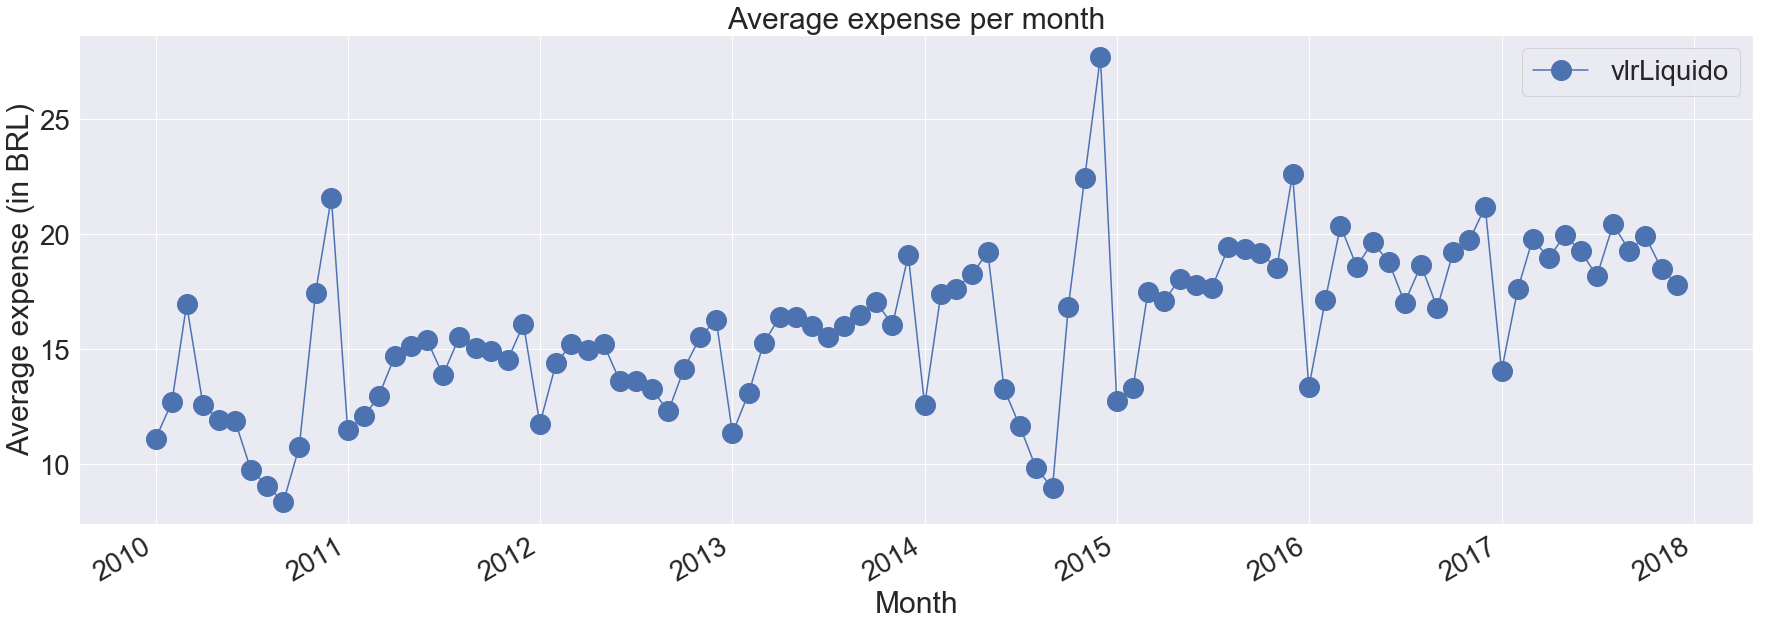

In [5]:
sns.set(font_scale=2.5)
plt.figure(figsize=(30,10))

df10 = df[df['numAno']>2009]

df10.groupby('numMes')['vlrLiquido'].mean().plot(marker='o',markersize=20)
plt.xlabel('Month')
plt.ylabel('Average expense (in BRL)')
plt.title('Average expense per month')


# plot agg
dftemp = (df10.groupby(['numMes','numAno'])['vlrLiquido'].sum()/(1e6)).reset_index()
dftemp['date']=0

for ix in dftemp.index.tolist():
    dftemp.loc[ix,'date'] = pd.to_datetime(str(dftemp.loc[ix,'numAno'])+'-'+str(dftemp.loc[ix,'numMes'])+'-01')
dftemp.plot(x='date',y='vlrLiquido',figsize=(30,10),marker='o',markersize=20)


plt.xlabel('Month')
plt.ylabel('Average expense (in BRL)')
plt.title('Average expense per month')

Clearly their are peaks in December. Also note the peaks at the end of 2011 and 2015 -- that corresponds to the end of the electoral cycle, and congressmen might be in a rush to deplete their budgets.

Let's take a closer look at outliers next.

## A closer look at the largest purchases.

The dataset contains a lot of interesting information, including data on trips and destinations. We will return to this eventually, but for now let's focus on overall expenditures.

For now, we restrict ourselves to the following features:
`'txNomeParlamentar','sgUF','sgPartido','txtDescricao','datEmissao','txtFornecedor','txtCNPJCPF','vlrLiquido'`

We will restict ourselve to purchases above 50k BRL.

In [6]:
# selected features
features = ['txNomeParlamentar','sgUF','sgPartido','txtDescricao','datEmissao','txtFornecedor','txtCNPJCPF','vlrLiquido']

# new dataframe constrained to the above features and only with purchases above 50k
dfS = df[features].copy()
dfS = dfS.loc[dfS['vlrLiquido']>5e4]
len(dfS)

387

Their are 387 purchases that cost more that 50k. Who were the congressmen responsible for them? Let's check the names that appear more than twice on this list.

In [7]:
names = dfS['txNomeParlamentar'].value_counts()
names = names[names>2]
print(len(names))
names

47


PR. MARCO FELICIANO                  10
ELCIONE BARBALHO                     10
GIVALDO CARIMBÃO                      9
ARNALDO FARIA DE SÁ                   9
GONZAGA PATRIOTA                      9
WELLINGTON ROBERTO                    9
ARLINDO CHINAGLIA                     9
LUCIO VIEIRA LIMA                     8
SILAS CÂMARA                          8
CARLOS MANATO                         8
SABINO CASTELO BRANCO                 7
SANDES JÚNIOR                         7
PADRE JOÃO                            6
FÉLIX MENDONÇA JÚNIOR                 6
JHONATAN DE JESUS                     6
RICARDO IZAR                          6
CLEBER VERDE                          5
ARTHUR LIRA                           5
GIACOBO                               5
DOMINGOS SÁVIO                        5
PROFESSORA DORINHA SEABRA REZENDE     5
ROSE DE FREITAS                       4
REGINALDO LOPES                       4
BENJAMIN MARANHÃO                     4
MACEDO                                4


Interesting. We have 47 people on this list. Let's order our outlier spenders by how much they spend. Below is a sorted list, with values in thousands of BRL.

In [8]:
outlier_spenders = (dfS.groupby('txNomeParlamentar')['vlrLiquido'].sum()/1e3).sort_values(ascending=False)
outlier_spenders

txNomeParlamentar
ARNALDO FARIA DE SÁ                  1506.040039
ARLINDO CHINAGLIA                    1057.880005
GIVALDO CARIMBÃO                      828.000000
ELCIONE BARBALHO                      732.612000
PR. MARCO FELICIANO                   726.000000
SANDES JÚNIOR                         681.349976
GONZAGA PATRIOTA                      645.700012
CARLOS MANATO                         629.039368
SABINO CASTELO BRANCO                 599.276123
WELLINGTON ROBERTO                    578.479004
FÉLIX MENDONÇA JÚNIOR                 559.000000
SILAS CÂMARA                          541.124023
LUCIO VIEIRA LIMA                     525.799988
RICARDO IZAR                          476.274994
JHONATAN DE JESUS                     465.500000
ARTHUR LIRA                           435.380005
CLEBER VERDE                          396.899323
PADRE JOÃO                            391.977509
RICARDO TRIPOLI                       377.303894
PROFESSORA DORINHA SEABRA REZENDE     358.595001
GI

Arnaldo Faria de Sá is definitely interesting -- he not only appears 9 times in the outlier list, but was a top spender in his aggregate outlier purchase. Let's look at the history of what he bought.

Target name: ARNALDO FARIA DE SÁ


Text(0.5,1,'Expenses by ARNALDO FARIA DE SÁ')

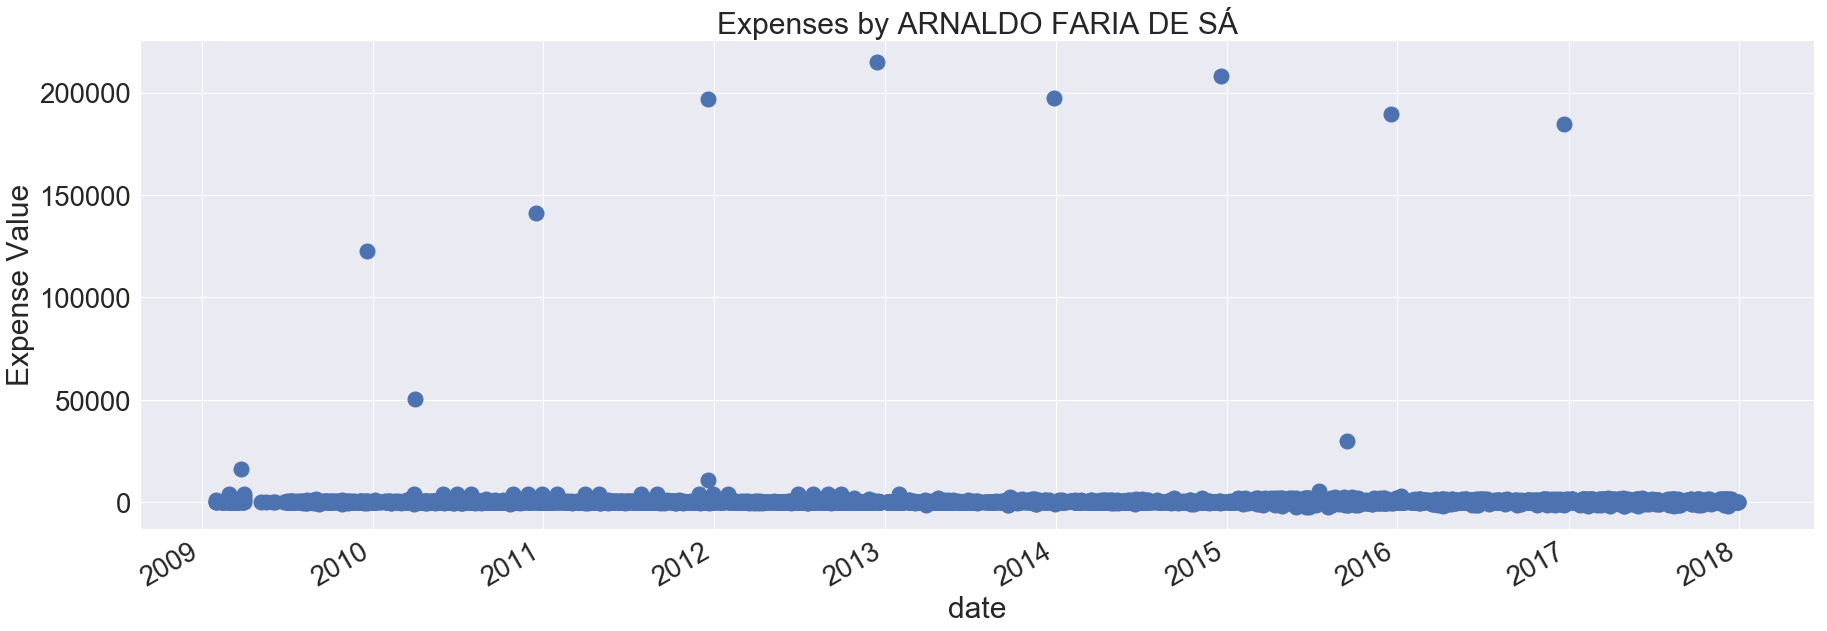

In [9]:
target = outlier_spenders.index.tolist()[0]
print('Target name: '+target)

ts = df.loc[df['txNomeParlamentar']==target,['datEmissao','vlrLiquido']].copy()

ts.sort_values('datEmissao',inplace=True)
ts.set_index('datEmissao', inplace=True)

# aggregate plot

ax = ts.plot(marker='o',linestyle='',figsize=(30,10),markersize=15)
ax.legend_.remove()
plt.xlabel('date')
plt.ylabel('Expense Value')
plt.title('Expenses by '+target)

That's weird. His expenses are usually pretty low, but every December he spends a lot of money on something. What is he purchasing? Let's check.

In [10]:
dfTarget = dfS[dfS['txNomeParlamentar']==target]
dfTarget

,txNomeParlamentar,sgUF,sgPartido,txtDescricao,datEmissao,txtFornecedor,txtCNPJCPF,vlrLiquido
34449,ARNALDO FARIA DE SÁ,SP,PTB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2012-12-14 00:00:00,BALCOLOR DIGITAL ATELIER GRAFICO LTDA,05511195000158,215000.0
388558,ARNALDO FARIA DE SÁ,SP,PTB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2013-12-27 00:00:00,BALCOLOR DIGITAL ATELIER GRAFICO LTDA,05511195000158,197370.0
750436,ARNALDO FARIA DE SÁ,SP,PTB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2011-12-19 00:00:00,BALCOLOR,05511195000158,197000.0
1124131,ARNALDO FARIA DE SÁ,SP,PTB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2010-12-17 00:00:00,BALCOLOR DIGITAL,05511195000158,141000.0
1124132,ARNALDO FARIA DE SÁ,SP,PTB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2010-04-01 00:00:00,BALCOLOR DIGITAL ATELIER GRÁFICO LTDA-ME,05511195000158,50400.0
1461869,ARNALDO FARIA DE SÁ,SP,PTB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2009-12-21 00:00:00,BALCOLOR DIGITAL,05511195000158,122850.0
1733104,ARNALDO FARIA DE SÁ,SP,PTB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2015-12-18 00:00:00,GRÁFICA TRÊS PONTAS,54450705000130,189600.0
2107824,ARNALDO FARIA DE SÁ,SP,PTB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2014-12-19 00:00:00,GRÁFICA TRÊS PONTAS,54450705000130,208320.0
2435999,ARNALDO FARIA DE SÁ,SP,PTB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2016-12-21 00:00:00,GRÁFICA TRÊS PONTAS,54450705000130,184500.0


He seems to be spending his money on printing services. Untill 2014 he used **BALCOLOR**, and afterwards **GRÁFICA TRES PONTAS**. Let's check exactly how much. When we track companies, we use their unique identifier CNPJ, since the input name in `txtFornecedor` may change.

In [11]:
# this routine produces expenditures by company
def agg_company(df):
    total_spent = df.groupby('txtCNPJCPF')['vlrLiquido'].sum()/1e3
    company_names = df.groupby('txtCNPJCPF')['txtFornecedor'].agg(lambda x: set(x))
    dfCom = pd.concat([total_spent,company_names],axis=1)
    return dfCom
    
agg_company(dfTarget)

,vlrLiquido,txtFornecedor
txtCNPJCPF,,
05511195000158,923.619995,"{BALCOLOR DIGITAL ATELIER GRAFICO LTDA, BALCOL..."
54450705000130,582.419983,{GRÁFICA TRÊS PONTAS}


The above code indicates he spent BRL\$923k with BALCOLOR, and BRL\$582k with GRÁFICA TRES PONTAS. In case you were wondering, [this is what google returns](https://www.google.com/maps/uv?hl=en&pb=!1s0x94ce5a3569ace38f%3A0x2ff4555fcad241d2!2m22!2m2!1i80!2i80!3m1!2i20!16m16!1b1!2m2!1m1!1e1!2m2!1m1!1e3!2m2!1m1!1e5!2m2!1m1!1e4!2m2!1m1!1e6!3m1!7e115!4shttps%3A%2F%2Flh5.googleusercontent.com%2Fp%2FAF1QipP3iPJULRh5zTQRA58PoZtgaJNvyUIYyUnImEH5%3Dw284-h160-k-no!5sGr%C3%A1fica%20tres%20pontas%20-%20Google%20Search&imagekey=!1e2!2sItUuFN6O97cAAAQJOMQ1nQ&sa=X&ved=0ahUKEwiR-b3io9vZAhWlt1kKHXkcDboQoioIbzAK) as the inside of Gráfica três pontas, which received over half a million Reais in 3 years from the congressman for their printing services.

Let's repeat this analysis with three other targets: Pr. Feliciano, Elcione Barbalho, and Arlindo Chingalia. The first two are the ones that have the largest number of outliers, and the latter is our second highest spender. To avoid double code, we will put our analysis in a function.

-------------------------
Target name: ARLINDO CHINAGLIA
Outlier expenses by ARLINDO CHINAGLIA


,txNomeParlamentar,sgUF,sgPartido,txtDescricao,datEmissao,txtFornecedor,txtCNPJCPF,vlrLiquido
33801,ARLINDO CHINAGLIA,SP,PT,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2012-12-27 00:00:00,ALL WIN PROPAGANDA LTDA,09023310000104,162580.0
750091,ARLINDO CHINAGLIA,SP,PT,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2011-12-26 00:00:00,ALL WIN PROPAGANDA LTDA,09023310000104,194100.0
1122604,ARLINDO CHINAGLIA,SP,PT,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2010-12-28 00:00:00,OURO GRAF ACABAMENTOS LTDA.,05098197000167,120000.0
1461054,ARLINDO CHINAGLIA,SP,PT,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2009-12-22 00:00:00,ALL WIN PROPAGANDA LTDA.,09023310000104,93000.0
1732749,ARLINDO CHINAGLIA,SP,PT,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2016-01-06 00:00:00,KARISMA IMPRESSOS E PAPELARIA LTDA - EPP,11416677000121,137900.0
2107483,ARLINDO CHINAGLIA,SP,PT,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2014-12-29 00:00:00,Unica - Indústria Gráfica e Editora Ltda,11580358000157,89300.0
2435405,ARLINDO CHINAGLIA,SP,PT,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2016-12-23 00:00:00,KARISMA IMPRESSOS E PAPELARIA LTDA - EPP,11416677000121,87000.0
2435406,ARLINDO CHINAGLIA,SP,PT,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2016-12-27 00:00:00,KARISMA IMPRESSOS E PAPELARIA LTDA - EPP,11416677000121,56400.0
2791391,ARLINDO CHINAGLIA,SP,PT,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2017-12-29 00:00:00,K9 INDUSTRIA GRAFICA E SERVICOS DE IMPRESSAO E...,09419299000198,117600.0


Expensed by comany in thousands of BRL:


,vlrLiquido,txtFornecedor
txtCNPJCPF,,
05098197000167,120.000000,{OURO GRAF ACABAMENTOS LTDA.}
09023310000104,449.679993,"{ALL WIN PROPAGANDA LTDA., ALL WIN PROPAGANDA ..."
09419299000198,117.599998,{K9 INDUSTRIA GRAFICA E SERVICOS DE IMPRESSAO ...
11416677000121,281.299988,{KARISMA IMPRESSOS E PAPELARIA LTDA - EPP}
11580358000157,89.300003,{Unica - Indústria Gráfica e Editora Ltda}


['05098197000167', '09023310000104', '09419299000198', '11416677000121', '11580358000157']


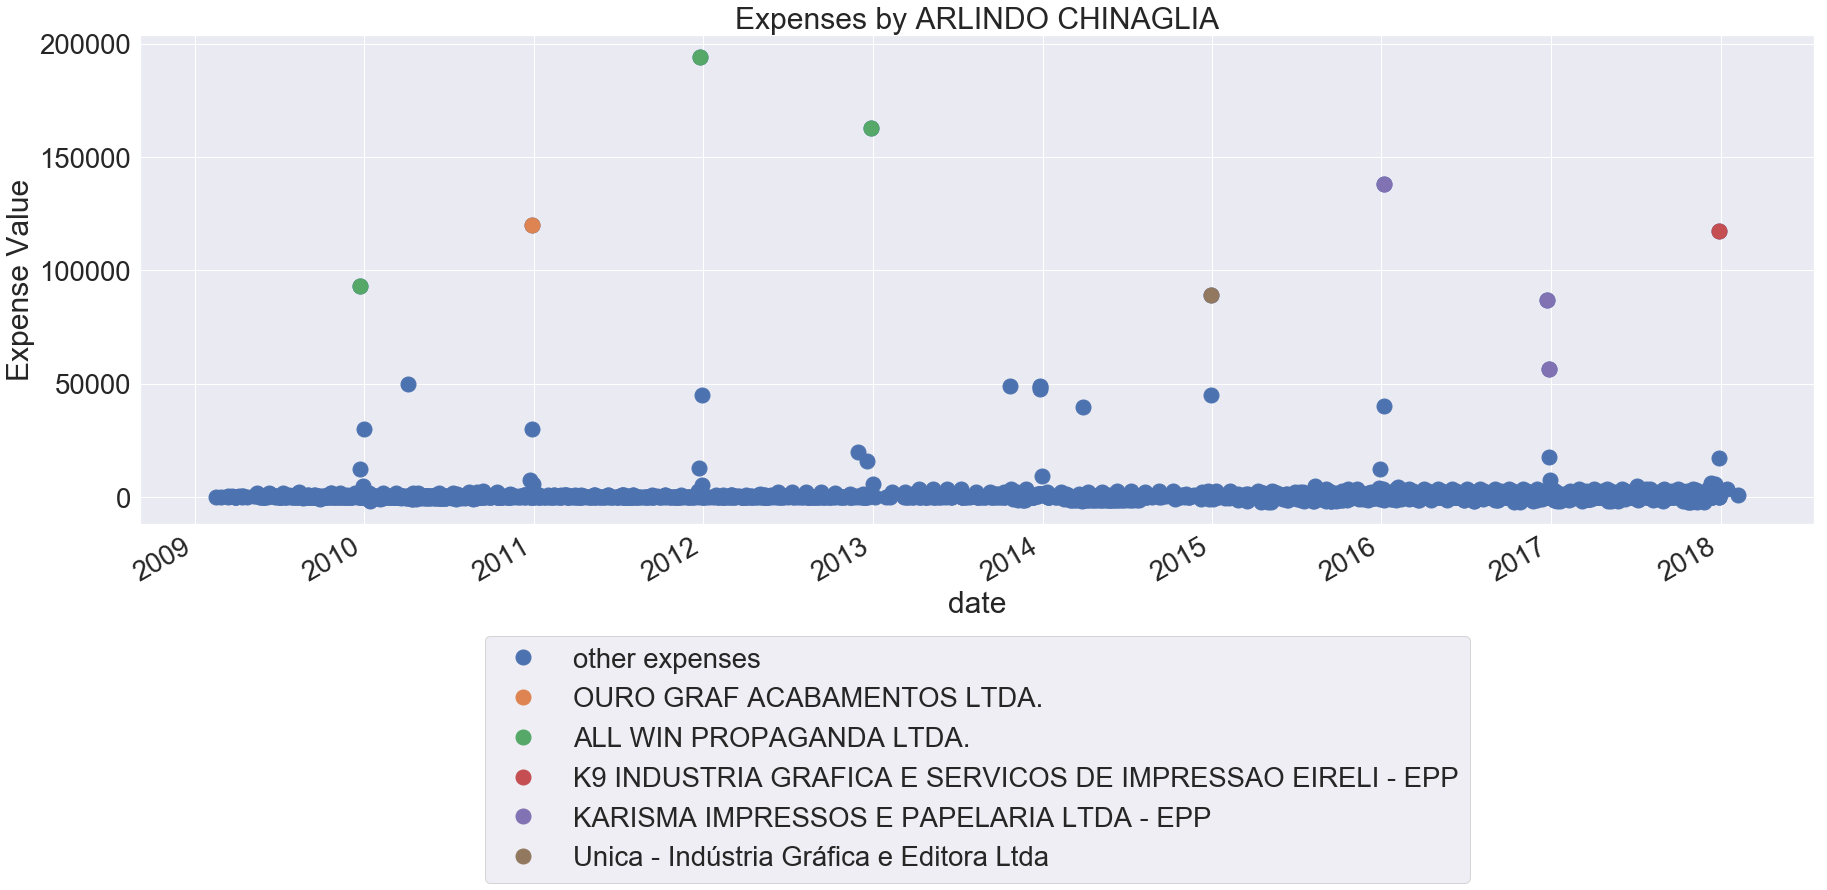

In [12]:
def analyze_target(target):
    sns.set(font_scale=2.5)
    print('-------------------------')
    print('Target name: '+target)

    
    # aggregate plot
    
    
    # print dataframe
    print('Outlier expenses by '+target)
    dfTarget = dfS[dfS['txNomeParlamentar']==target]
    display(dfTarget)
    
    # print expenditures by company
    print('Expensed by comany in thousands of BRL:')
    dfTarget_agg = agg_company(dfTarget)
    display(dfTarget_agg)
    
    
    # print aggregate time series
    ts = df.loc[df['txNomeParlamentar']==target,['datEmissao','vlrLiquido']].copy()

    ts.sort_values('datEmissao',inplace=True)
    ts.set_index('datEmissao', inplace=True)
    
    ax = ts.plot(marker='o',linestyle='',figsize=(30,10),markersize=15,label='other expenses')

  
    
    # target company ids
    target_ids = dfTarget_agg.index.tolist()
    print(target_ids)
    company_names = {cnpj:list(dfTarget_agg.loc[cnpj,'txtFornecedor'])[0] for cnpj in target_ids}
    
    for cnpj in target_ids:
        ix1 = dfS['txNomeParlamentar']==target
        ix2 = dfS['txtCNPJCPF']==cnpj

        ts = dfS.loc[ix1&ix2,['datEmissao','vlrLiquido']].copy()

        ts.sort_values('datEmissao',inplace=True)
        ts.set_index('datEmissao', inplace=True)
        ts.plot(marker='o',linestyle='',figsize=(30,10),markersize=15,label=cnpj,ax=ax)
        
    ax.legend(['other expenses']+[company_names[cnpj] for cnpj in target_ids],loc=9, bbox_to_anchor=(0.5, -0.2))
    ax.set_xlabel('date')
    ax.set_ylabel('Expense Value')
    ax.set_title('Expenses by '+target)

    
    
targets = [outlier_spenders.index[1],names.index[0],names.index[1]]

analyze_target(targets[0])
    
    

Chingalia spend about BRL\$ 450k with **ALL WIN PROPAGANDA**. According to their CNPJ registery, [this](https://www.google.com/maps/place/R.+Adele+Zarzur,+871+-+Jardim+Sao+Jose,+S%C3%A3o+Paulo+-+SP,+Brazil/@-23.4810483,-46.7129099,3a,75y,235.97h,90t/data=!3m7!1e1!3m5!1sjaX7MbxvSx5yJWTLFstxwQ!2e0!6s%2F%2Fgeo1.ggpht.com%2Fcbk%3Fpanoid%3DjaX7MbxvSx5yJWTLFstxwQ%26output%3Dthumbnail%26cb_client%3Dsearch.TACTILE.gps%26thumb%3D2%26w%3D86%26h%3D86%26yaw%3D235.97464%26pitch%3D0%26thumbfov%3D100!7i13312!8i6656!4m5!3m4!1s0x94cef90b41d4cc85:0x4099c6084ff4aa5d!8m2!3d-23.4810978!4d-46.7129627) is their location on google maps...

-------------------------
Target name: PR. MARCO FELICIANO
Outlier expenses by PR. MARCO FELICIANO


,txNomeParlamentar,sgUF,sgPartido,txtDescricao,datEmissao,txtFornecedor,txtCNPJCPF,vlrLiquido
1994039,PR. MARCO FELICIANO,SP,PSC,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2015-08-31 00:00:00,GRAFICA MARGE - LTDA - ME,04418791000125,53000.0
1994040,PR. MARCO FELICIANO,SP,PSC,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2015-12-18 00:00:00,GRAFICA MARGE - LTDA - ME,04418791000125,63000.0
1994042,PR. MARCO FELICIANO,SP,PSC,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2015-10-20 00:00:00,MENORAH EDITORA E GRAVADORA-ME,13728749000100,90000.0
2338885,PR. MARCO FELICIANO,SP,PSC,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2014-12-08 00:00:00,GRAFICA MARGE - LTDA - ME,04418791000125,65000.0
2338886,PR. MARCO FELICIANO,SP,PSC,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2014-10-27 00:00:00,MENORAH EDITORA E GRAVADORA-ME,13728749000100,67500.0
2338887,PR. MARCO FELICIANO,SP,PSC,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2014-12-01 00:00:00,MENORAH EDITORA E GRAVADORA-ME,13728749000100,87500.0
2688959,PR. MARCO FELICIANO,SP,PSC,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2016-10-17 00:00:00,GRAFICA MARGE - LTDA - ME,04418791000125,75000.0
3027708,PR. MARCO FELICIANO,SP,PSC,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2017-06-03 00:00:00,GRAFICA MARGE - LTDA - ME,04418791000125,75000.0
3027709,PR. MARCO FELICIANO,SP,PSC,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2017-09-20 00:00:00,GRAFICA MARGE - LTDA - ME,04418791000125,75000.0
3027710,PR. MARCO FELICIANO,SP,PSC,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2017-12-08 00:00:00,GRAFICA MARGE LTDA - ME,04418791000125,75000.0


Expensed by comany in thousands of BRL:


,vlrLiquido,txtFornecedor
txtCNPJCPF,,
04418791000125,481.0,"{GRAFICA MARGE LTDA - ME, GRAFICA MARGE - LTDA..."
13728749000100,245.0,{MENORAH EDITORA E GRAVADORA-ME}


['04418791000125', '13728749000100']


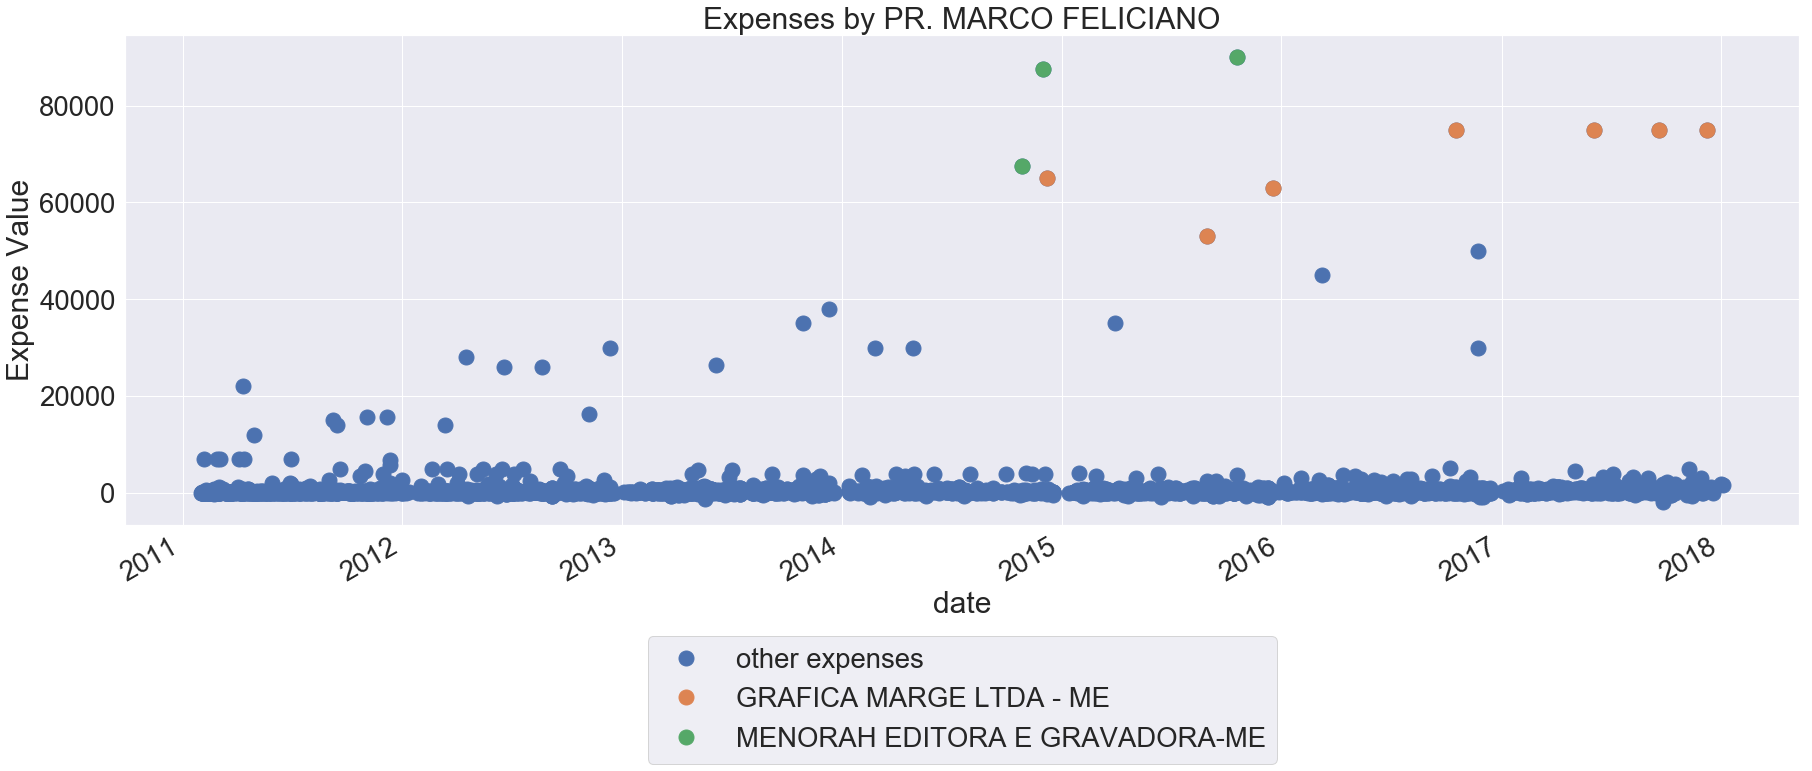

In [13]:
analyze_target(targets[1])

Elcione Barbalhos is simpler. She spent most of her outlying expensed with 1 company: **Stilo Gráfica**, having spend BRL\$732k with them since 2010 (about 80k a year). Their CNPJ registration is points to the address of "AlphaGraphics" in Brasília, you can see it [here](https://www.google.com/maps/place/AlphaGraphics/@-15.8150746,-47.8941869,3a,75y,219.54h,90t/data=!3m7!1e1!3m5!1s_kNxMqARidezPQvOLw0NaA!2e0!6s%2F%2Fgeo3.ggpht.com%2Fcbk%3Fpanoid%3D_kNxMqARidezPQvOLw0NaA%26output%3Dthumbnail%26cb_client%3Dsearch.TACTILE.gps%26thumb%3D2%26w%3D234%26h%3D106%26yaw%3D219.53659%26pitch%3D0%26thumbfov%3D100!7i13312!8i6656!4m12!1m6!3m5!1s0x935a3ace7b944557:0xeb2dcbeadb63502e!2sAlphaGraphics!8m2!3d-15.8151595!4d-47.8942992!3m4!1s0x935a3ace7b944557:0xeb2dcbeadb63502e!8m2!3d-15.8151595!4d-47.8942992). Note that we also have recurring expenditures at the end of the year -- perhaps a yearly bill?

-------------------------
Target name: ELCIONE BARBALHO
Outlier expenses by ELCIONE BARBALHO


,txNomeParlamentar,sgUF,sgPartido,txtDescricao,datEmissao,txtFornecedor,txtCNPJCPF,vlrLiquido
98656,ELCIONE BARBALHO,PA,PMDB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2012-12-19 00:00:00,STILO GRÁFICA E EDITORA LTDA,00539486000130,87300.0
823760,ELCIONE BARBALHO,PA,PMDB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2011-09-13 00:00:00,STILO GRÁFICA E EDITORA LTDA.,00539486000130,67200.0
1188046,ELCIONE BARBALHO,PA,PMDB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2010-12-06 00:00:00,STILO GRÁFICA E EDITORA LTDA,00539486000130,61920.0
1809483,ELCIONE BARBALHO,PA,PMDB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2015-12-01 00:00:00,STILO GRAFICA E EDITORA LTDA,00539486000130,99900.0
1809484,ELCIONE BARBALHO,PA,PMDB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2015-06-23 00:00:00,STILO GRAFICA E EDITORA LTDA,00539486000130,82320.0
2168170,ELCIONE BARBALHO,PA,PMDB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2014-12-10 00:00:00,STILO GRAFICA E EDITORA LTDA,00539486000130,96252.0
2510703,ELCIONE BARBALHO,PA,PMDB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2016-04-29 00:00:00,STILO GRAFICA E EDITORA LTDA,00539486000130,67850.0
2510704,ELCIONE BARBALHO,PA,PMDB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2016-07-13 00:00:00,STILO GRAFICA E EDITORA LTDA,00539486000130,58870.0
2510705,ELCIONE BARBALHO,PA,PMDB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2016-12-07 00:00:00,STILO GRAFICA E EDITORA LTDA,00539486000130,54300.0
2861765,ELCIONE BARBALHO,PA,PMDB,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2017-05-29 00:00:00,STILO GRAFICA E EDITORA LTDA,00539486000130,56700.0


Expensed by comany in thousands of BRL:


,vlrLiquido,txtFornecedor
txtCNPJCPF,,
00539486000130,732.612,"{STILO GRAFICA E EDITORA LTDA, STILO GRÁFICA E..."


['00539486000130']


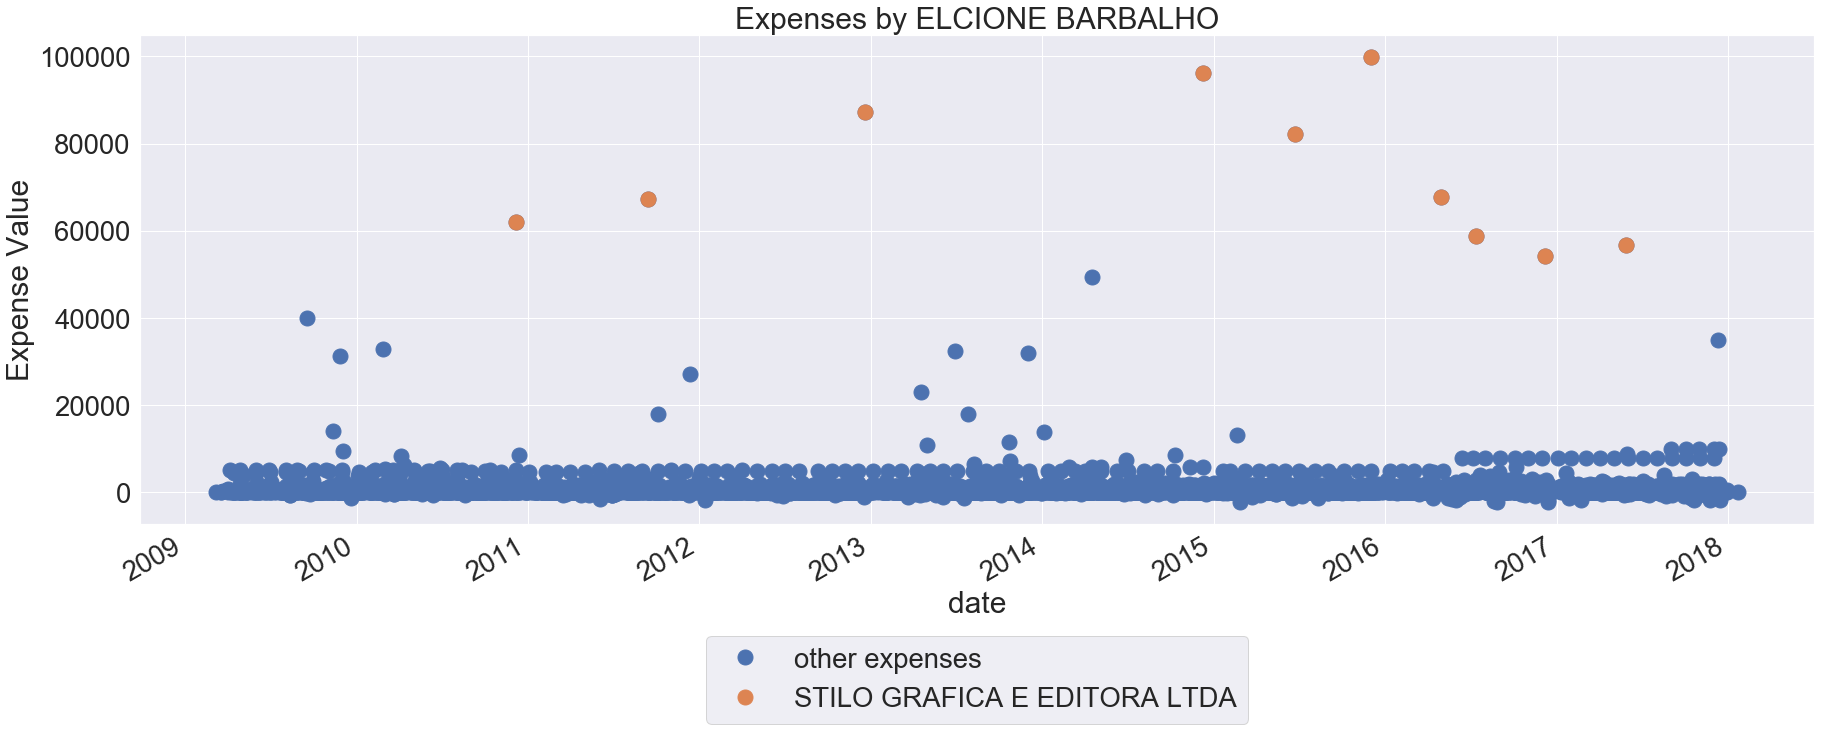

In [14]:
analyze_target(targets[2])

Pr. Felciano has spent well over BRL\$700K since 2014 in two companies: Grafica Marge and Menorah Editor. Between late 2014 and 2016, it received at least \$481k. [Here is its location](https://www.google.com/maps/place/R.+Progresso,+474+-+Centro,+Francisco+Morato+-+SP,+07901-170,+Brazil/@-23.283268,-46.7445818,3a,75y,159.92h,90t/data=!3m7!1e1!3m5!1sChCo4QsRzYk_1KKADX6IwA!2e0!6s%2F%2Fgeo2.ggpht.com%2Fcbk%3Fpanoid%3DChCo4QsRzYk_1KKADX6IwA%26output%3Dthumbnail%26cb_client%3Dsearch.TACTILE.gps%26thumb%3D2%26w%3D86%26h%3D86%26yaw%3D159.91849%26pitch%3D0%26thumbfov%3D100!7i13312!8i6656!4m5!3m4!1s0x94cee6d44ceae68b:0x302a94a182ae15df!8m2!3d-23.2833504!4d-46.7446059) on Google Maps. How about Menorah music? It received at leas \$250K in one year. [Here is its registered address.](https://www.google.com/maps/place/R.+Tup%C3%A3,+91+-+Parque+Paulista,+Francisco+Morato+-+SP,+Brazil/@-23.3022277,-46.7337338,3a,75y,275.46h,90t/data=!3m8!1e1!3m6!1s_YS5-8YSiPhmQtSBnGjSmQ!2e0!3e11!6s%2F%2Fgeo1.ggpht.com%2Fmaps%2Fphotothumb%2Ffd%2Fv1%3Fbpb%3DChAKDnNlYXJjaC5UQUNUSUxFEkAKEgkZzlmNu-bOlBG5EcyiYgM-nBIKDZ1cHPIVdvwk5BoSCT1BqpK75s6UEUBuy3KHxXuyKgoNNF0c8hUc_CTkGgQIVhBW%26gl%3DUS!7i13312!8i6656!4m5!3m4!1s0x94cee6bb8d59ce19:0x9c3e0362a2cc11b9!8m2!3d-23.3022156!4d-46.7338212)

## Clustering Congress

Next we will cluster congress members by their average spending patterns. This is not an ideal approach since, for example, PCA+averaging will remove outliers. Nevertheless, this might potentially be informative.

We will group congress people in terms of their average expense per expenditure category.

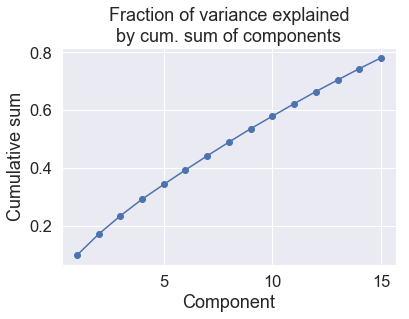

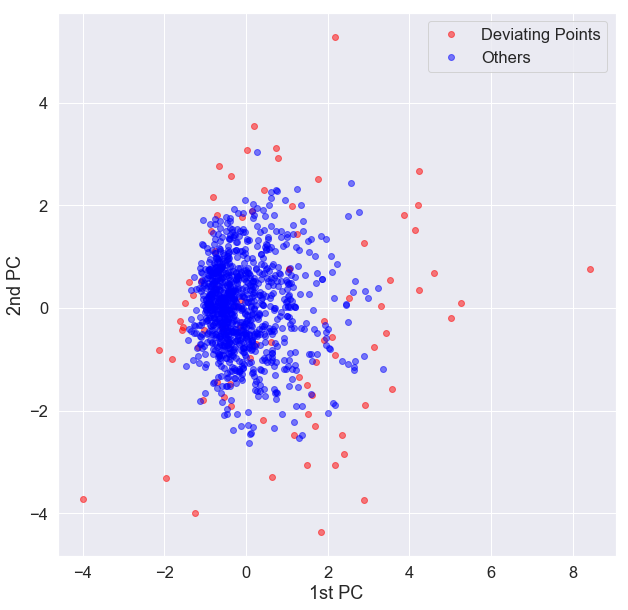

In [15]:
# group by expenditure
dfAgg = df.groupby(['txNomeParlamentar','txtDescricao'])['vlrLiquido'].mean()#.reset_index()

# group by number of expenses
dfCount = df.groupby(['txNomeParlamentar','txtDescricao'])['vlrLiquido'].count()#.reset_index()

# creat mask where number of expenses in category is smaller that 2 is set to 0
dfCount  = dfCount.apply(lambda x : 1 if x>2 else 0)
dfAgg = dfAgg*dfCount
dfAgg = dfAgg.reset_index()

# we remove congresspeople that spent less than 100k Reais in total

# compute total expendiure per congressperson
dfTotal = df.groupby('txNomeParlamentar')['vlrLiquido'].sum().reset_index()
relevant_spenders = list(dfTotal.loc[dfTotal['vlrLiquido']>1e5,'txNomeParlamentar'])

# cut to relevant spenders
dfAgg = dfAgg[dfAgg['txNomeParlamentar'].isin(relevant_spenders)]

# comute average expense
dfAvgExp = pd.pivot_table(dfAgg,values='vlrLiquido',index='txNomeParlamentar',columns='txtDescricao', fill_value=0)


# compute average profile of congressperson
#dfProfile = 100*dfAvgExp.divide(dfAvgExp.sum(axis=1),axis=0)
#dfProfile = 100*dfAvgExp.divide(dfAvgExp.sum(axis=1),axis=0)
dfProfile = dfAvgExp
dfProfile = (dfProfile-dfProfile.mean())/dfProfile.std()


# create PCA object
n_components = 15
pca = PCA(n_components=n_components, whiten=True)
pca.fit(dfProfile)

# Plot explained variance
sns.set(font_scale=1.5)
plt.plot(np.arange(1,n_components+1),np.cumsum(pca.explained_variance_ratio_),'o-')
plt.xlabel('Component')
plt.ylabel('Cumulative sum')
plt.title('Fraction of variance explained\nby cum. sum of components')

# transform data
dfTransform = pd.DataFrame(pca.transform(dfProfile),index=dfAvgExp.index)


# we determine senators that deviate a lot from average in terms of the average l2 norm of positive deviations from average
# sytematic dev
dfNorm = dfProfile.applymap(lambda x: x**2 if x>0 else 0)
dfNorm = np.sqrt(dfNorm.sum(axis=1)/dfProfile.shape[1])

# total dev
# dfNorm = dfProfile.applymap(lambda x: 1 if x>2 else 0)
# dfNorm = dfNorm.sum(axis=1)

# set deviation threshold
dev_thresh = 1.5

bad_ix = dfNorm>=dev_thresh

# plot
plt.figure(figsize=(10,10))
plt.plot(dfTransform.loc[bad_ix,0],dfTransform.loc[bad_ix,1],'o',alpha=.5,color='red',label = 'Deviating Points')
plt.plot(dfTransform.loc[~bad_ix,0],dfTransform.loc[~bad_ix,1],'o',alpha=.5,color='blue', label = 'Others')
plt.legend()
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
# target deviators
target_dev = dfNorm[bad_ix].sort_values(ascending=False).index.tolist()

Let's take a closer look at the parties and the states that the deviating points are members of.

In [16]:
# create congress profile
dfInfo = df.groupby(['txNomeParlamentar','sgUF','sgPartido'])['vlrLiquido'].sum().reset_index()
dfInfo = dfInfo.set_index('txNomeParlamentar')
print('State count')
display(dfInfo.loc[target_dev,'sgUF'].value_counts())

print('Party count')
dfInfo.loc[target_dev,'sgPartido'].value_counts()

#df[df['txNomeParlamentar']==target_dev[0]]
#dfProfile.loc[target_dev[0],:]

State count


/Users/flavio/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


SP    10
BA     8
PR     6
RJ     5
MA     5
AM     5
PA     4
MG     4
AL     4
RR     3
DF     3
RS     3
AP     3
CE     3
TO     3
PE     3
SE     2
RO     2
RN     1
MS     1
PB     1
MT     1
AC     1
Name: sgUF, dtype: int64

Party count


PMDB    10
PSD     10
PTB      8
PR       8
PSDB     6
DEM      6
PT       6
PP       5
PSB      5
PROS     4
PRB      4
PDT      3
SD       2
REDE     1
PSC      1
PV       1
PHS      1
Name: sgPartido, dtype: int64

Next lets look at the congressperson with the largest average deviations, and where he spent his money.

In [17]:
target = target_dev[2]
print('Name: '+target)
df[df['txNomeParlamentar']==target]
display(dfInfo.loc[target,:])
display(dfProfile.loc[target,:])
max_cat = dfProfile.loc[target,:].idxmax()
max_cat

Name: JOAQUIM PASSARINHO


sgUF                   PA
sgPartido             PSD
vlrLiquido    1.49494e+06
Name: JOAQUIM PASSARINHO, dtype: object

txtDescricao
AQUISIÇÃO DE MATERIAL DE ESCRITÓRIO.                            -0.261992
AQUISIÇÃO OU LOC. DE SOFTWARE SERV. POSTAIS ASS.                -0.288372
ASSINATURA DE PUBLICAÇÕES                                        3.355387
COMBUSTÍVEIS E LUBRIFICANTES.                                   -0.423098
CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.                   -1.073440
DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.                             0.440532
Emissão Bilhete Aéreo                                           -0.128461
FORNECIMENTO DE ALIMENTAÇÃO DO PARLAMENTAR                      -0.737361
HOSPEDAGEM ,EXCETO DO PARLAMENTAR NO DISTRITO FEDERAL.           0.095010
LOCAÇÃO DE VEÍCULOS AUTOMOTORES OU FRETAMENTO DE EMBARCAÇÕES    -0.687427
LOCAÇÃO OU FRETAMENTO DE AERONAVES                              -0.293420
LOCAÇÃO OU FRETAMENTO DE EMBARCAÇÕES                            -0.065733
LOCAÇÃO OU FRETAMENTO DE VEÍCULOS AUTOMOTORES                    0.766775
LOCOMOÇÃO, ALIMENTAÇÃO E 

'PASSAGENS TERRESTRES, MARÍTIMAS OU FLUVIAIS'

He deviates a lot in office supplies, maintaing an office and software. The defiation in flights and food is expected, since he is from Acre. Let's look at his expenses.

-------------------------
Target name: MANOEL SALVIANO
Outlier expenses by MANOEL SALVIANO


,txNomeParlamentar,sgUF,sgPartido,txtDescricao,datEmissao,txtFornecedor,txtCNPJCPF,vlrLiquido


Expensed by comany in thousands of BRL:


,vlrLiquido,txtFornecedor
txtCNPJCPF,,


[]


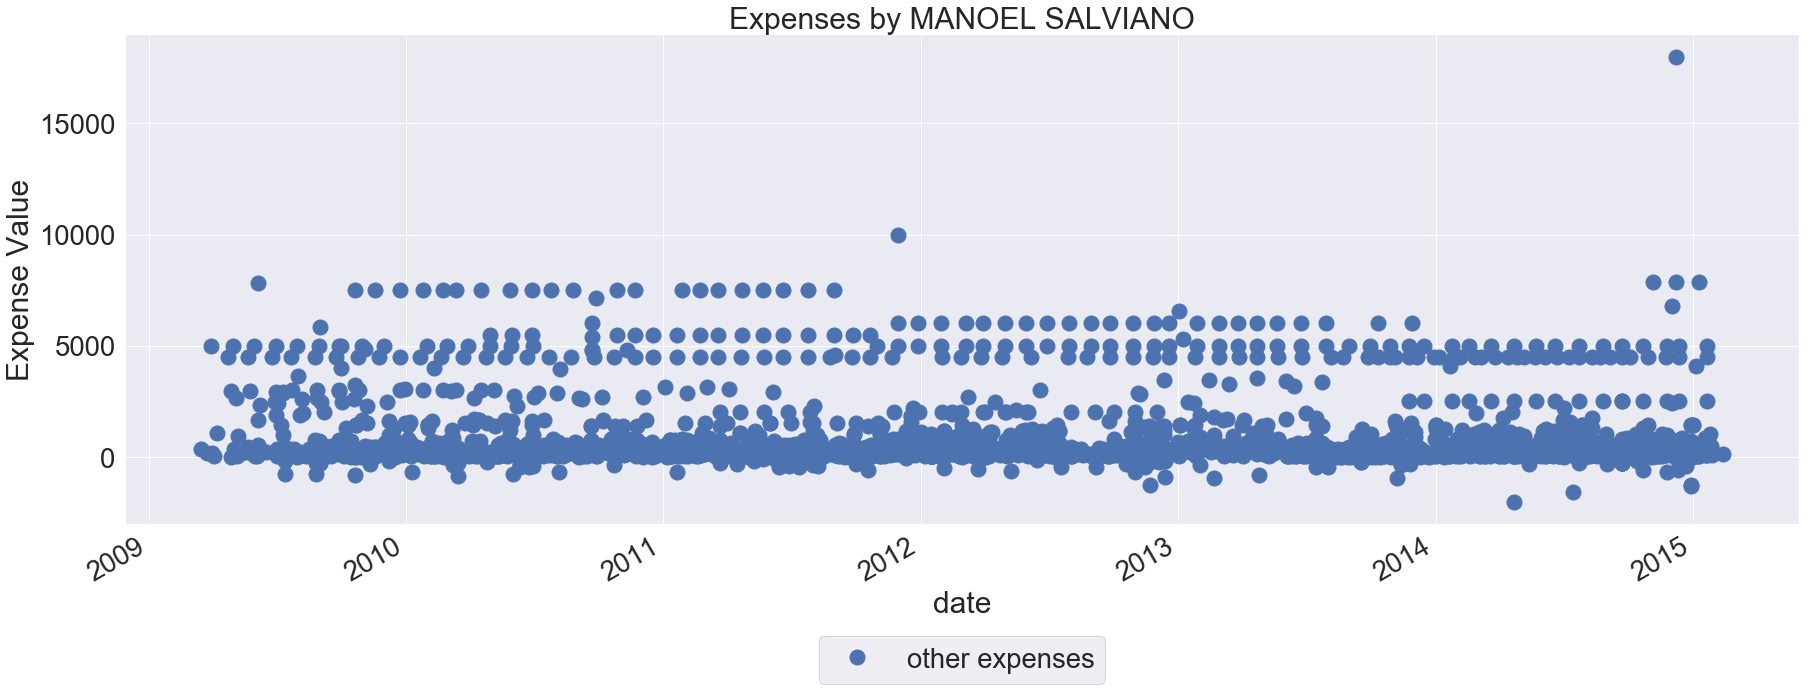

In [18]:
analyze_target(target_dev[1])

A few very high exxpenses on printing and air taxi, but nothing we haven't seen before. But you see quite a number of expxenses above 10k. Where is he spending that money?

In [19]:
company_names = df.groupby('txtCNPJCPF')['txtFornecedor'].agg(lambda x: list(set(x))).to_dict()

In [20]:
ix1 = df['txNomeParlamentar']==target
ix2 = df['txtDescricao']==max_cat
ix = ix1&ix2
company_exp = df.loc[ix,:].groupby('txtCNPJCPF')['vlrLiquido'].sum().sort_values(ascending=False)
cnpj_list = company_exp.index.tolist()
df_exp = pd.DataFrame(company_exp)
df_exp['company_name'] = [company_names[cnpj] for cnpj in df_exp.index.tolist()]
df_exp

,vlrLiquido,company_name
txtCNPJCPF,,
07575651000159,2066.989990,"[VRG LINHAS AÉREAS SA., GOL / VRG LINHAS AÉRE..."
15747686000156,53.029999,[ARAPARI NAVEGACAO]
04743076000320,53.029999,"[BANNACH NAVEGAÇÃO TLDA, BANNACH NAVEGACAO, B..."


In [42]:
df.loc[df['txNomeParlamentar']==target,:].groupby('txtDescricao')['vlrLiquido'].sum()

txtDescricao
AQUISIÇÃO DE MATERIAL DE ESCRITÓRIO.                          14700.000000
AQUISIÇÃO OU LOC. DE SOFTWARE SERV. POSTAIS ASS.               4875.000000
ASSINATURA DE PUBLICAÇÕES                                      3316.280029
COMBUSTÍVEIS E LUBRIFICANTES.                                 48162.390625
DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.                         630781.562500
Emissão Bilhete Aéreo                                        633142.937500
FORNECIMENTO DE ALIMENTAÇÃO DO PARLAMENTAR                    12503.940430
HOSPEDAGEM ,EXCETO DO PARLAMENTAR NO DISTRITO FEDERAL.         2473.510010
LOCAÇÃO OU FRETAMENTO DE VEÍCULOS AUTOMOTORES                110130.148438
MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE PARLAMENTAR    249264.875000
PASSAGENS AÉREAS                                              11002.080078
SERVIÇO DE TÁXI, PEDÁGIO E ESTACIONAMENTO                      1722.000000
SERVIÇOS POSTAIS                                             873961.062500
TELEFONIA   

# list(set(list(df['txNomeParlamentar'])))

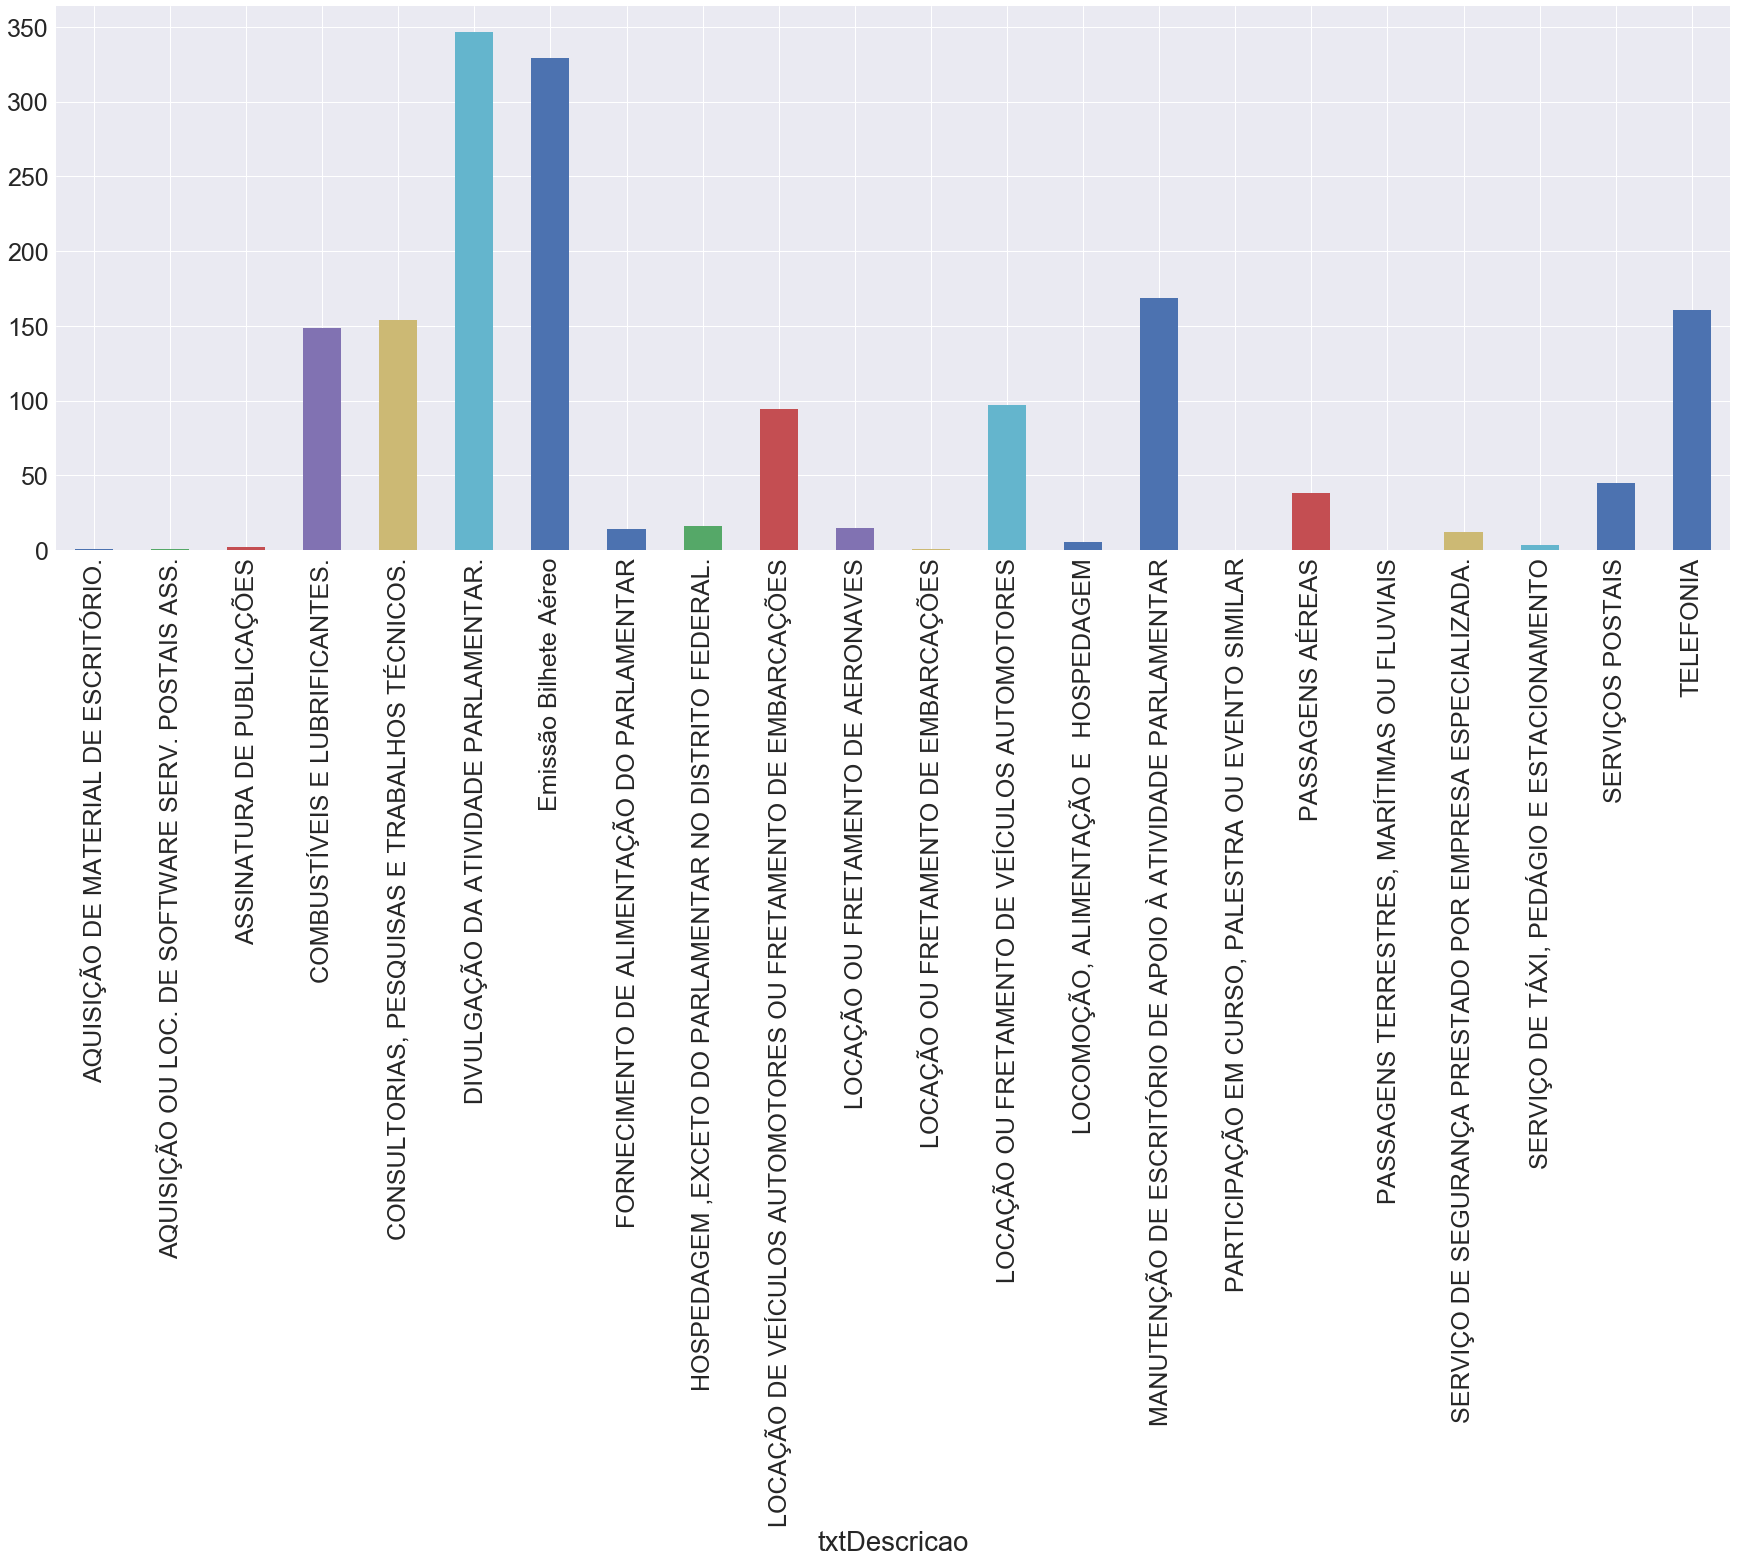

In [134]:
(df.groupby('txtDescricao')['vlrLiquido'].sum()/1e6).plot(kind='bar',figsize = (30,10))


In [39]:
# selected features
features = ['txNomeParlamentar','sgUF','sgPartido','txtDescricao','datEmissao','txtFornecedor','txtCNPJCPF','vlrLiquido']

# new dataframe constrained to the above features and only with purchases above 50k
dfS = df[features].copy()
dfS = dfS.loc[dfS['vlrLiquido']>1000]
len(dfS)

342434

Target name: EDUARDO BOLSONARO
-------------------------
Target name: EDUARDO BOLSONARO
Outlier expenses by EDUARDO BOLSONARO


,txNomeParlamentar,sgUF,sgPartido,txtDescricao,datEmissao,txtFornecedor,txtCNPJCPF,vlrLiquido
1805790,EDUARDO BOLSONARO,SP,PSC,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2015-12-09 00:00:00,ACESSO COMERCIO E SERVIÇO DE INFORMATICA LTDA,10392148000172,3179.000000
1805794,EDUARDO BOLSONARO,SP,PSC,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2015-05-09 00:00:00,DIGITAL RIVER,08165429000221,1308.000000
1805805,EDUARDO BOLSONARO,SP,PSC,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2015-06-01 00:00:00,ORCHID ELIAS,45884374887,4000.000000
1805806,EDUARDO BOLSONARO,SP,PSC,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2015-08-01 00:00:00,ORCHID ELIAS,45884374887,4000.000000
1805807,EDUARDO BOLSONARO,SP,PSC,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2015-09-01 00:00:00,ORCHID ELIAS,45884374887,4000.000000
1805808,EDUARDO BOLSONARO,SP,PSC,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2015-10-01 00:00:00,ORCHID ELIAS,45884374887,4000.000000
1805809,EDUARDO BOLSONARO,SP,PSC,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2015-11-01 00:00:00,ORCHID ELIAS,45884374887,4000.000000
1805810,EDUARDO BOLSONARO,SP,PSC,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2015-07-01 00:00:00,ORCHID ELIAS,45884374887,4000.000000
1805811,EDUARDO BOLSONARO,SP,PSC,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2015-12-01 00:00:00,ORCHID ELIAS,45884374887,4000.000000
1805812,EDUARDO BOLSONARO,SP,PSC,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2016-01-01 00:00:00,ORCHID ELIAS,45884374887,4000.000000


Expensed by comany in thousands of BRL:


,vlrLiquido,txtFornecedor
txtCNPJCPF,,
00540252000103,3.424480,"{Papelaria ABC Com. e Ind. Ltda., Papelaria AB..."
01832635000118,177.279053,{TAM LINHAS AÉREAS S.A.}
02012862000160,66.949524,"{LATAM AIRLINES - TAM, Latam Airlines - TAM, T..."
02575829000148,20.564671,"{AVIANCA BRASIL, Cia Aérea - AVIANCA, Ocean Ai..."
04541599000121,16.799999,"{P & L PATRIMONIO LTDA. - EPP, P & L PATRIMÔNI..."
06164253000187,124.792183,"{Gol Linhas Aereas, GOL LINHAS AEREAS INTELIGE..."
07354003000172,5.400000,{RAINBOW BUREAU E SOLUÇÕES DIGITAIS.}
07575651000159,33.529140,"{GOL - LINHAS AÉREAS S/A, Gol Linhas Aereas, G..."
08165429000221,3.408000,"{DIGITAL RIVER DO BRASIL, DIGITAL RIVER}"


['00540252000103', '01832635000118', '02012862000160', '02575829000148', '04541599000121', '06164253000187', '07354003000172', '07575651000159', '08165429000221', '08570617000154', '09296295000160', '09296295001484', '10392148000172', '10892621000180', '10892621000261', '13688724000111', '18509834000192', '34028316004281', '34028316500181', '34028316577052', '37135001000153', '38024675000143', '43283811005976', '45884374887']


txtDescricao
COMBUSTÍVEIS E LUBRIFICANTES.                                 15159.190430
DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.                          35511.441406
Emissão Bilhete Aéreo                                         57142.589844
FORNECIMENTO DE ALIMENTAÇÃO DO PARLAMENTAR                     6534.490234
HOSPEDAGEM ,EXCETO DO PARLAMENTAR NO DISTRITO FEDERAL.        10107.700195
LOCAÇÃO OU FRETAMENTO DE VEÍCULOS AUTOMOTORES                119583.351562
MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE PARLAMENTAR    155767.906250
PASSAGENS AÉREAS                                             513083.531250
SERVIÇO DE TÁXI, PEDÁGIO E ESTACIONAMENTO                      6735.830078
SERVIÇOS POSTAIS                                              74117.578125
TELEFONIA                                                     22677.279297
Name: vlrLiquido, dtype: float32

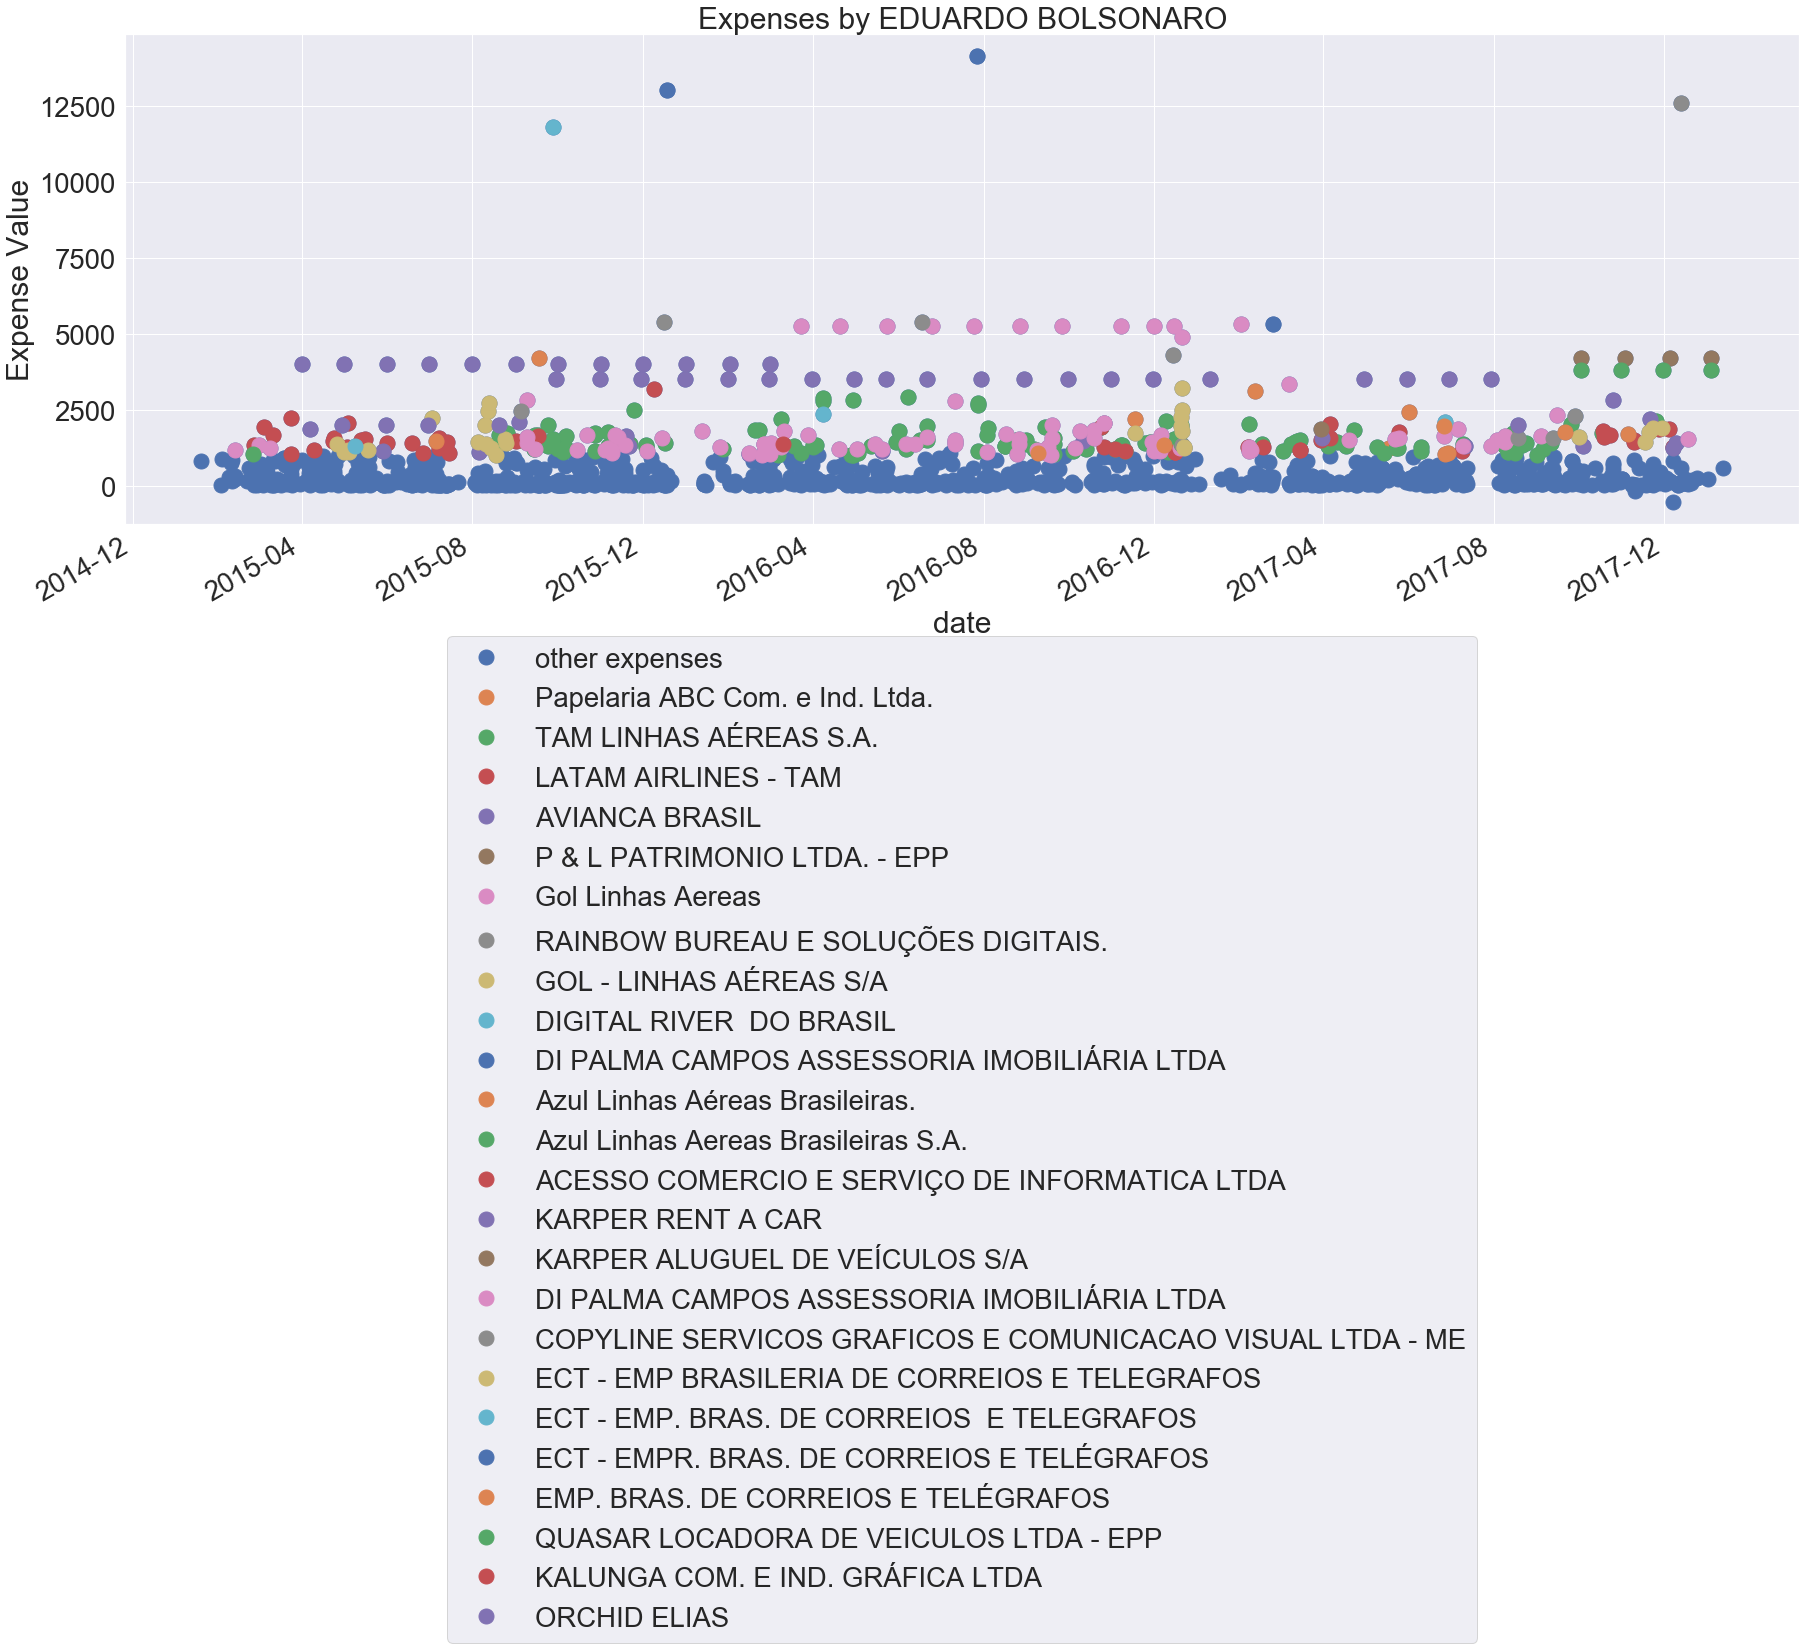

In [43]:
target = 'EDUARDO BOLSONARO'
print('Target name: '+target)

analyze_target(target)
df.loc[df['txNomeParlamentar']==target,:].groupby('txtDescricao')['vlrLiquido'].sum()

In [37]:
dfTarget = dfS[dfS['txNomeParlamentar']==target]
dfTarget

,txNomeParlamentar,sgUF,sgPartido,txtDescricao,datEmissao,txtFornecedor,txtCNPJCPF,vlrLiquido
147271,JAIR BOLSONARO,RJ,PSC,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2012-11-23 00:00:00,MEIRELLES CUNHA GRÁFICA LTDA - ME,32337784000134,24100.000000
147273,JAIR BOLSONARO,RJ,PSC,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2012-12-31 00:00:00,MEIRELLES CUNHA GRÁFICA LTDA - ME,32337784000134,21600.000000
505584,JAIR BOLSONARO,RJ,PSC,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2013-06-10 00:00:00,R. A. MANDULA SERVIÇOS GRÁFICOS E EDITORA LTDA,27677913000101,20000.000000
505585,JAIR BOLSONARO,RJ,PSC,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2013-12-10 00:00:00,R. A. MANDULA SERVIÇOS GRÁFICOS E EDITORA LTDA.,27677913000101,19500.000000
876216,JAIR BOLSONARO,RJ,PSC,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2011-12-27 00:00:00,PAPELARIA ABC COM E IND LTDA,00540252000103,15350.200195
876258,JAIR BOLSONARO,RJ,PSC,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2011-03-25 00:00:00,M. R. CEDA IMPRESSOS LTDA,40166704000153,32300.000000
876260,JAIR BOLSONARO,RJ,PSC,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2011-08-12 00:00:00,M. R. CEDA IMPRESSOS LTDA,40166704000153,18000.000000
876261,JAIR BOLSONARO,RJ,PSC,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2011-11-04 00:00:00,M. R. CEDA IMPRESSOS LTDA,40166704000153,17100.000000
876262,JAIR BOLSONARO,RJ,PSC,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2011-12-07 00:00:00,M. R. CEDA IMPRESSOS LTDA,40166704000153,19000.000000
1237929,JAIR BOLSONARO,RJ,PSC,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2010-11-16 00:00:00,PAPELARIA ABC COMÉRCIO E INDÚSTRIA LTDA,00540252000103,21411.199219


In [4]:
from tqdm import tqdm

n = 500
for i in tqdm(range(1000)):
    A = np.random.rand(n,n)
    B = np.random.rand(n,n)
    C = A.dot(B)

100%|██████████| 1000/1000 [00:08<00:00, 120.05it/s]


In [45]:
df.groupby('txNomeParlamentar').count()

,idecadastro,nuCarteiraParlamentar,nuLegislatura,sgUF,sgPartido,codLegislatura,numSubCota,txtDescricao,numEspecificacaoSubCota,txtDescricaoEspecificacao,...,numMes,numAno,numParcela,txtPassageiro,txtTrecho,numLote,numRessarcimento,vlrRestituicao,nuDeputadoId,ideDocumento
txNomeParlamentar,,,,,,,,,,,,,,,,,,,,,
ABEL MESQUITA JR.,1346,1346,1346,1346,1346,1346,1346,1346,1346,187,...,1346,1346,1346,861,858,1346,1346,1346,1346,1346
ABELARDO CAMARINHA,2017,2017,2017,2017,2017,2017,2017,2017,2017,386,...,2017,2017,2017,478,479,2017,2017,2017,2017,2017
ABELARDO LUPION,4116,4116,4116,4116,4116,4116,4116,4116,4116,1225,...,4116,4116,4116,763,765,4116,4116,4116,4116,4116
ACELINO POPÓ,3215,3215,3215,3215,3215,3215,3215,3215,3215,785,...,3215,3215,3215,656,662,3215,3215,3215,3215,3215
ACÁCIO JÚNIOR,24,24,24,24,24,24,24,24,24,1,...,24,24,24,5,5,24,24,24,24,24
ACÉLIO CASAGRANDE,894,894,894,894,894,894,894,894,894,198,...,894,894,894,82,86,894,894,894,894,894
ADAIL CARNEIRO,1111,1111,1111,1111,1111,1111,1111,1111,1111,87,...,1111,1111,1111,346,350,1111,1111,1111,1111,1111
ADALBERTO CAVALCANTI,1398,1398,1398,1398,1398,1398,1398,1398,1398,110,...,1398,1398,1398,591,593,1398,1398,1398,1398,1398
ADELMO CARNEIRO LEÃO,2927,2927,2927,2927,2927,2927,2927,2927,2927,702,...,2927,2927,2927,540,544,2927,2927,2927,2927,2927
